In [ ]:
!# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('./bone-break-classification-image-dataset.zip', 'r')
zip_ref.extractall('./')
zip_ref.close()

In [ ]:
import torch

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import torchvision.utils as utils

import torch.utils.data as data

from sklearn.metrics import classification_report

In [ ]:
transformm = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

In [ ]:
data_dir = '/content/drive/MyDrive/bone/dataset/Bone Break Classification/Bone Break Classification/'
dataset = datasets.ImageFolder(root=data_dir,transform=transformm)

In [ ]:
dataset.classes

['Avulsion fracture',
 'Comminuted fracture',
 'Fracture Dislocation',
 'Greenstick fracture',
 'Hairline Fracture',
 'Impacted fracture',
 'Longitudinal fracture',
 'Oblique fracture',
 'Pathological fracture',
 'Spiral Fracture']

In [ ]:
class_num = len(dataset.classes)

In [ ]:
from torch.utils.data import random_split

train_ratio = 0.8

train_data, val_data = random_split(dataset, [train_ratio, 1-train_ratio])

In [ ]:
BATCH_SIZE = 16

train_dl = data.DataLoader(train_data,shuffle=True, batch_size=BATCH_SIZE,)
val_dl =  data.DataLoader(val_data, batch_size=BATCH_SIZE)

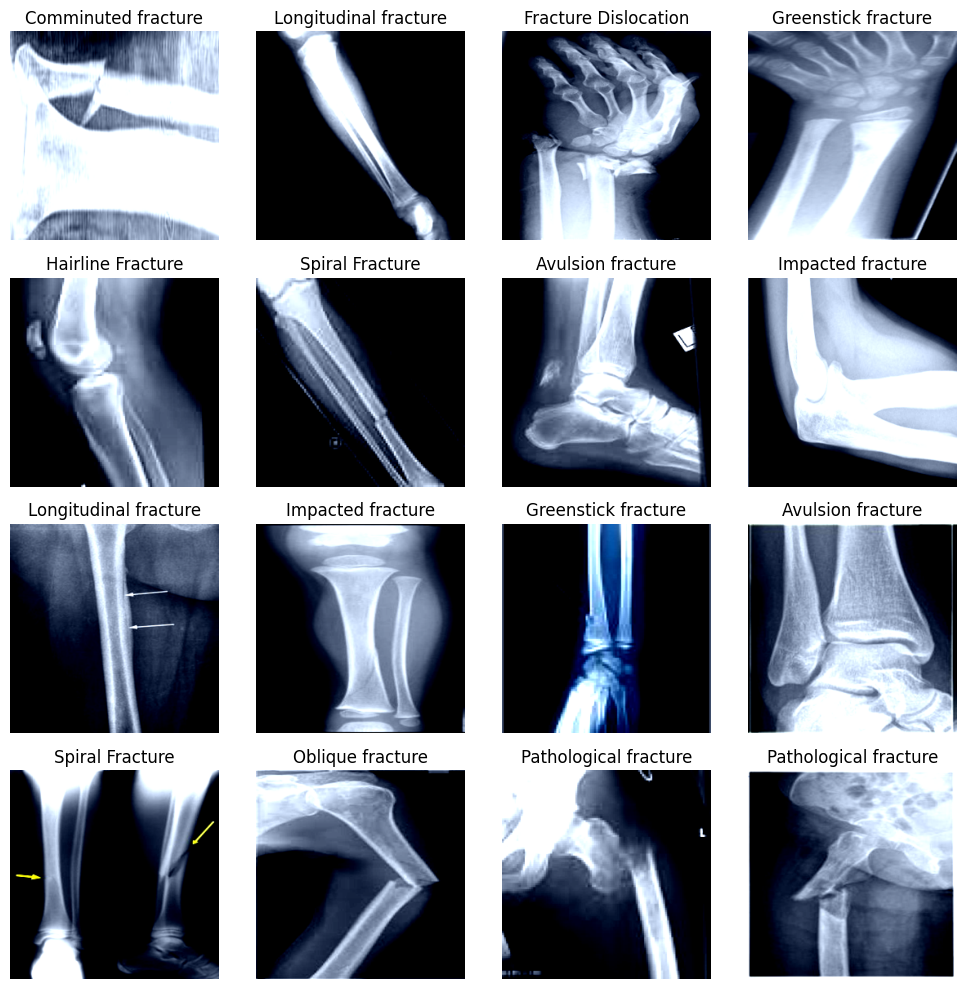

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_dl)
images, labels = next(dataiter)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i in range(16):
    ax = axes[i // 4, i % 4]
    ax.imshow(np.transpose(images[i].numpy() / 2 + 0.5, (1, 2, 0)))
    ax.set_title(dataset.classes[labels[i]])
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
class CNN(torch.nn.Module):
    def __init__(self,class_num):
        super().__init__()
        self.model = torch.nn.Sequential(

            torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),

            torch.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Dropout(0.2),

            torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),


            torch.nn.Dropout(0.2),
            torch.nn.Flatten(),
            torch.nn.Linear(64*32*32, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, class_num))

    def forward(self, x):
        return self.model(x)

In [ ]:
model = CNN(class_num)
print(model.parameters)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
loss_fn = loss_fn.to(device)

epoches = 10

<bound method Module.parameters of CNN(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.2, inplace=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.2, inplace=False)
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=65536, out_features=128, bias=True)
    (13): ReLU()
    (14): Linear(in_features=128, out_features=64, bias=True)
    (15): ReLU()
    (16): Linear(in_features=64, out_features=10, bias=True)
  )
)>


In [ ]:
def train(model,epoches,optimizer,loss_fn,train_dl,val_dl):
    train_losses = []
    valid_losses = []

    avg_train_losses = []
    avg_valid_losses = []


    for epoch in range(epoches):

        train_loss = 0
        val_loss = 0

        model.train()
        for i, (images,labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs,labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        correct = 0
        total = 0

        model.eval()

        for images, labels in val_dl:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)

            loss = loss_fn(output, labels)

            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            valid_losses.append(loss.item())

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        if(epoch+1) % 2 == 0 :
            print(f'Epoch {epoch+1}/{epoches}:')
            print(f'Training loss = {train_loss:.4f}')
            print(f'Validation accuracy: {correct / total:4f}')
            print(f'Validation loss: {valid_loss:.4f}')
            print()

    return {'train_loss':avg_train_losses,'val_loss': avg_valid_losses}


In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

8421226

In [ ]:
history = train(model,epoches,optimizer,loss_fn,train_dl,val_dl)

Epoch 2/10:
Training loss = 2.2631
Validation accuracy: 0.186667
Validation loss: 2.2732

Epoch 4/10:
Training loss = 2.1860
Validation accuracy: 0.253333
Validation loss: 2.2633

Epoch 6/10:
Training loss = 1.9367
Validation accuracy: 0.333333
Validation loss: 2.3241

Epoch 8/10:
Training loss = 1.5672
Validation accuracy: 0.324444
Validation loss: 2.7033

Epoch 10/10:
Training loss = 1.2684
Validation accuracy: 0.311111
Validation loss: 3.2004



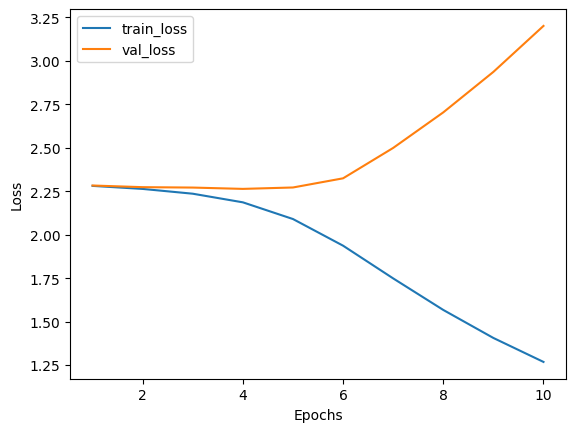

In [ ]:
plt.plot(range(1,epoches+1), history['train_loss'],label='train_loss')
plt.plot(range(1,epoches+1), history['val_loss'],label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()